In [90]:
!pip install tiingo
!pip install NeuralProphet
!pip install Pandas
!pip install numpy

In [91]:
import requests
from datetime import date, datetime, timedelta
import pandas as pd
import numpy as np
from tiingo import TiingoClient
from neuralprophet import NeuralProphet, set_log_level
set_log_level("CRITICAL")
import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters()
%matplotlib inline
from sklearn.metrics import mean_squared_error

In [92]:
config = {
'api_key': 'YOUR TIINGO API', 
'session': True
}
client = TiingoClient(config)

In [93]:
ticker = 'btcusd'
frequency = '15min'
end_date = date.today()
bars_ahead_forecast = 60
history = client.get_crypto_price_history([ticker],
          endDate = end_date,
          resampleFreq = frequency)

In [94]:
df_hist = pd.DataFrame.from_dict(history[0]['priceData'])
df = pd.DataFrame(df_hist, columns=['date', 'close'])
df.rename(columns = {'date':'ds', 'close':'y'}, inplace = True)
df["ds"] = df["ds"].astype("datetime64[ns]")

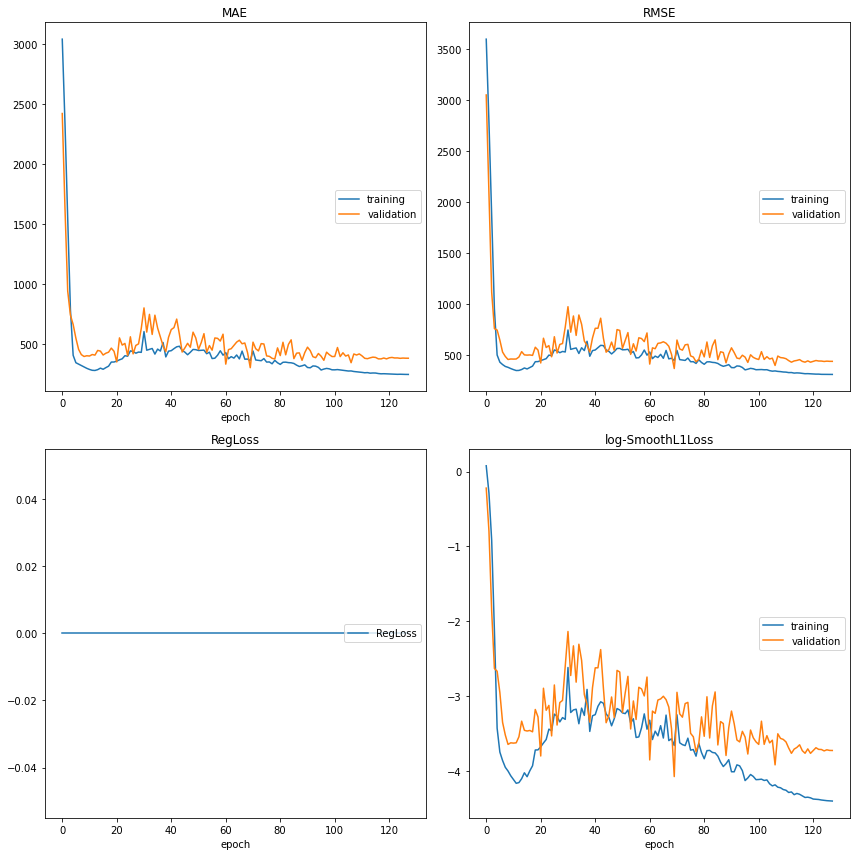

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\forecaster.py:2060: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(future_df)

WARNING - (py.warnings._showwarnmsg) - C:\Users\peter\anaconda3\lib\site-packages\neuralprophet\forecaster.py:1406: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_end_to_append)



MAE
	training         	 (min:  244.340, max: 3039.658, cur:  244.340)
	validation       	 (min:  300.603, max: 2419.705, cur:  379.467)
RMSE
	training         	 (min:  311.247, max: 3598.488, cur:  311.310)
	validation       	 (min:  369.253, max: 3051.399, cur:  439.570)
RegLoss
	RegLoss          	 (min:    0.000, max:    0.000, cur:    0.000)
log-SmoothL1Loss
	training         	 (min:   -4.404, max:    0.077, cur:   -4.404)
	validation       	 (min:   -4.077, max:   -0.221, cur:   -3.728)


In [95]:
m = NeuralProphet(
    n_changepoints = 6,
    changepoints_range = 0.90,
)
df_train, df_val = m.split_df(df, freq='auto', valid_p = (0.15))
metrics = m.fit(df_train, validation_df=df_val, freq='H',progress="plot-all")
future = m.make_future_dataframe(df, periods=bars_ahead_forecast,n_historic_predictions=len(df))
forecast = m.predict(future)

In [96]:
# Mean Absolute Percentge Error (MAPE) the closer to 0 the better
def mape(y_a, y_f):
    return np.mean(np.abs((y_a - y_f) / y_a))

In [97]:
# Display the MAPE for this model run
y_actual = df_train.y
y_forecast = df_val.y
print("MEAN ABSOLUTE PERCENTAGE ERROR FOR THIS MODEL:" + " " + "{:.1%}".format(mape(y_actual, y_forecast)))

MEAN ABSOLUTE PERCENTAGE ERROR FOR THIS MODEL: 4.7%


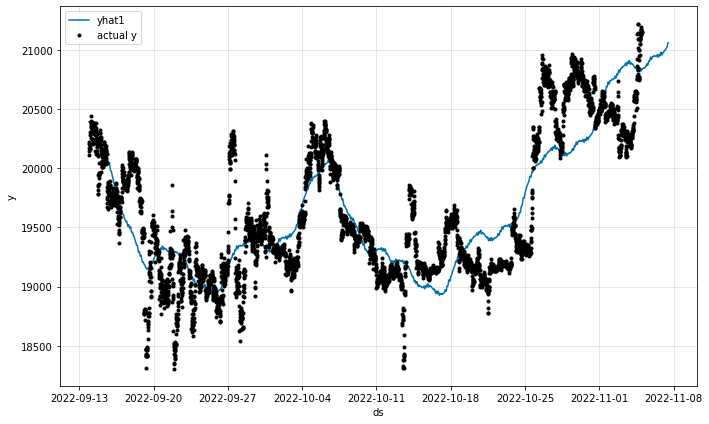

In [98]:
fig_forecast = m.plot(forecast)